# Lab Week 9: Part-of-Speech Tagging 

This week we are learning about part-of-speech (POS) tagging.  This involves deciding the correct part-of speech tag (e.g., noun, verb, adjective etc) for each word in a sentence.  Since the correct tag for each word depends not only on the current word but on the tags of those words around it, it is generally viewed as a **sequence labelling** problem.  In other words, for a given sequence of words, we are asking what is the most likely sequence of tags?


In [1]:
###mount google drive

#from google.colab import drive
#drive.mount('/content/drive')

import nltk
nltk.download('punkt')
nltk.download('stopwords')

import sys
import operator
#make sure you append the path where your utils.py file is.
#sys.path.append('/content/drive/My Drive/NLE Notebooks/Week4LabsSolutions/')
#sys.path.append('/Users/juliewe/Documents/teaching/NLE/NLE2021/w4/Week4LabsSolutions/')
#from utils import *



[nltk_data] Downloading package punkt to /home/poppy/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /home/poppy/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## Average PoS tag ambiguity 
The Part-of-Speech (PoS) tag ambiguity of a word type is a measure of how varied the PoS tags are for that type.   Note that here, we talk about the ambiguity of a word type rather than a word token because any given token has a single tag but different occurrences of the same type may have different tags.  For example, some occurrences of the word *bank* have the tag *noun* whereas others have the tag *verb*

Some types are always (or almost always) labelled with the same PoS tag, so exhibit no (or very little) ambiguity. It is easy to predict the correct PoS tag for such words. 

On the other hand, a type that is commonly labelled by a variety of different PoS tags exhibits a high level of ambiguity, and is more challenging to deal with.

In this session, we are going to be considering two measures of a type's ambiguity. We will be using the Wall Street Journal corpus as it has been hand-annotated with part of speech tags.  A 10% sample of it is available via NLTK via the `treebank` corpus reader.   
We will consider 
* a simple measure that just **counts** the number of different tags that label the type. 
* a more complex information-theoretic measure based on **entropy**.

First, we can use the treebank's method `tagged_words()` to get a list of all tokens in the corpus tagged with their POS.

In [2]:
from nltk.corpus import treebank

taggedWSJ=treebank.tagged_words()

taggedWSJ[0:10]

[('Pierre', 'NNP'),
 ('Vinken', 'NNP'),
 (',', ','),
 ('61', 'CD'),
 ('years', 'NNS'),
 ('old', 'JJ'),
 (',', ','),
 ('will', 'MD'),
 ('join', 'VB'),
 ('the', 'DT')]

In [3]:
for tuple1 in taggedWSJ[0:10]:
    print(tuple1[0])

Pierre
Vinken
,
61
years
old
,
will
join
the


In [4]:
nltk.download('treebank')

[nltk_data] Downloading package treebank to /home/poppy/nltk_data...
[nltk_data]   Package treebank is already up-to-date!


True

### Exercise 1.1
Write a function `find_tag_distributions(tokentaglist)` which finds the (frequency) distributions of tags for every word in the input.
* input: a list of pairs (token,tag)
* returns: a dictionary of dictionaries.  The key to the outermost dictionary should be the word and the key to each internal dictionary should be the tag.  The value associated with the tag in the internal dictionary should be its frequency of occurrence.

Test your function on `taggedWSJ` and look at the tag distribution for the word `the`.   You should find that you get:

`{DT: 4038, 'NNP':1, 'JJ':5, 'CD':1}`



In [5]:
print(taggedWSJ)

[('Pierre', 'NNP'), ('Vinken', 'NNP'), (',', ','), ...]


In [6]:
def find_tag_distributions(tokentaglist):
    tokens_dict_outer = {}
    for token, tag in tokentaglist:
        tag_dict = tokens_dict_outer.get(token, {})
        tag_dict[tag] = tag_dict.get(tag, 0)+1
        tokens_dict_outer[token] = tag_dict
        
    return tokens_dict_outer


In [7]:
distsWSJ = find_tag_distributions(taggedWSJ)

distsWSJ

{'Pierre': {'NNP': 1},
 'Vinken': {'NNP': 2},
 ',': {',': 4885},
 '61': {'CD': 5},
 'years': {'NNS': 115},
 'old': {'JJ': 24},
 'will': {'MD': 280, 'NN': 1},
 'join': {'VB': 4},
 'the': {'DT': 4038, 'NNP': 1, 'JJ': 5, 'CD': 1},
 'board': {'NN': 30},
 'as': {'IN': 333, 'RB': 52},
 'a': {'DT': 1874, 'JJ': 2, 'IN': 1, 'LS': 1},
 'nonexecutive': {'JJ': 5},
 'director': {'NN': 32},
 'Nov.': {'NNP': 23, 'NN': 1},
 '29': {'CD': 5},
 '.': {'.': 3828},
 'Mr.': {'NNP': 375},
 'is': {'VBZ': 671},
 'chairman': {'NN': 45},
 'of': {'IN': 2319},
 'Elsevier': {'NNP': 1},
 'N.V.': {'NNP': 3},
 'Dutch': {'NNP': 1, 'JJ': 2},
 'publishing': {'VBG': 4, 'NN': 9},
 'group': {'NN': 43},
 'Rudolph': {'NNP': 3},
 'Agnew': {'NNP': 1},
 '55': {'CD': 10},
 'and': {'CC': 1505, 'JJ': 3, 'IN': 1, 'NN': 2},
 'former': {'JJ': 19},
 'Consolidated': {'NNP': 2},
 'Gold': {'NNP': 2},
 'Fields': {'NNP': 2},
 'PLC': {'NNP': 13},
 'was': {'VBD': 367},
 'named': {'VBN': 20, 'VBD': 2},
 '*-1': {'-NONE-': 1123},
 'this': {'DT': 

### Exercise 1.2
Write a function `simple_pos_ambiguity` which can take the tagged WSJ text and returns a dictionary containing the number of part of speech tags which each word type has.  Note that this is simply the length of the dictionary associated with that word in the output from `find_tag_distributions`.

Check that you get the following results:
the: 4
white: 2
show: 3

In [8]:
def simple_pos_ambiguity(taggedtext):
    tags_per_word = {}
    tag_dists_dict = find_tag_distributions(taggedtext)
    for key, value in tag_dists_dict.items():
        tags_per_word[key] = len(value.keys())
    return tags_per_word


In [9]:
dict1 = simple_pos_ambiguity(taggedWSJ)
dict1["show"]
print(dict1)

{'Pierre': 1, 'Vinken': 1, ',': 1, '61': 1, 'years': 1, 'old': 1, 'will': 2, 'join': 1, 'the': 4, 'board': 1, 'as': 2, 'a': 4, 'nonexecutive': 1, 'director': 1, 'Nov.': 2, '29': 1, '.': 1, 'Mr.': 1, 'is': 1, 'chairman': 1, 'of': 1, 'Elsevier': 1, 'N.V.': 1, 'Dutch': 2, 'publishing': 2, 'group': 1, 'Rudolph': 1, 'Agnew': 1, '55': 1, 'and': 4, 'former': 1, 'Consolidated': 1, 'Gold': 1, 'Fields': 1, 'PLC': 1, 'was': 1, 'named': 2, '*-1': 1, 'this': 1, 'British': 2, 'industrial': 1, 'conglomerate': 1, 'A': 3, 'form': 2, 'asbestos': 1, 'once': 2, 'used': 3, '*': 1, 'to': 3, 'make': 2, 'Kent': 1, 'cigarette': 1, 'filters': 1, 'has': 2, 'caused': 2, 'high': 3, 'percentage': 1, 'cancer': 1, 'deaths': 1, 'among': 1, 'workers': 1, 'exposed': 1, 'it': 1, 'more': 3, 'than': 1, '30': 1, 'ago': 2, 'researchers': 1, 'reported': 2, '0': 1, '*T*-1': 1, 'The': 2, 'fiber': 1, 'crocidolite': 1, 'unusually': 1, 'resilient': 1, 'enters': 1, 'lungs': 1, 'with': 1, 'even': 3, 'brief': 2, 'exposures': 1, 'caus

In [10]:
def simple_pos_ambiguity_from_solutions(tag_dists):
    return {word:len(tag_dist.keys()) for word,tag_dist in tag_dists.items()}

#wsjreader=WSJCorpusReader()
#taggedWSJ=wsjreader.tagged_words()
ambiguity=simple_pos_ambiguity_from_solutions(distsWSJ)
words=['the','white','show']
for word in words:
    print("{}: {}".format(word,ambiguity[word]))

the: 4
white: 2
show: 3


### Exercise 1.3
Find the mean average value of the `simple_pos_ambiguity` score for word types in the WSJ.

In [11]:
def mean_pos_ambiguity(taggedwords):
    tags_per_word = simple_pos_ambiguity(taggedwords)
    SUM = 0 
    for value in tags_per_word.values():
        SUM += value
    mean = SUM/ len(tags_per_word.keys())
    return mean

In [12]:
mean_pos_ambiguity(taggedWSJ)

1.1106544165054804

In [13]:
# the slicker version from solutions
import numpy as np

ambiguity=simple_pos_ambiguity_from_solutions(distsWSJ)

print(np.mean(list(ambiguity.values())))

1.1106544165054804


## Entropy as a Measure of Tag Ambiguity

**Entropy** is a measure of uncertainty. A word will have high entropy when it occurs the same number of times with each part of speech. There is maximum uncertainty as to which part of speech it has.

The larger the part of speech tagset, the greater the potential for uncertainty, and the higher the entropy can be.

In the cell below we see a function `entropy`. It's argument is a list of counts (which in our case are counts of how many times a word appeared with a given part of speech).

Check that you understand how the code implements this definition of entropy:
$$H([x_1,\ldots,x_n])= - \sum_{i=1}^nP(x_i)\log_2 P(x_i)$$
where $n$ is the number of PoS tags, and $x_i$ is a count of how many times the word was labelled with the $i$th PoS tag.

In [14]:
import math

def entropy(counts):            # counts = list of counts of occurrences of tags
    total = sum(counts)         # get total number of occurrences
    if not total: return 0      # if zero occurrences in total, then 0 entropy
    entropy = 0
    for i in counts:            # for each tag count
        p = i/total      # probability that the token occurs with this tag
        try:
            entropy += p * math.log(p,2) # add to entropy
        except ValueError: pass     # if p==0, then ignore this p
    return -entropy if entropy else entropy   # only negate if nonzero, otherwise 
                                              # floats can return -0.0, which is weird.


### Exercise 2.1
Experiment with the `entropy` function.
- It takes a list of counts as its argument.
- Compare the entropy of a list where all counts are the same with the entropy of a list of different counts.
- See what happens when you vary the length of the list of counts.

In [15]:
#from lab 9 solutions

entropy([10,10,10])

1.584962500721156

In [16]:
entropy([5,5,5]) # same entropy

1.584962500721156

In [17]:
entropy([10,10,10,10,10]) # higher entropy if larger list

2.321928094887362

In [18]:
entropy([1000,1]) # entropy low if one clearly more likely

0.011397802630112312

In [19]:
entropy([1000])

0.0

In [20]:
entropy([100000,10,10,10,10]) # even lower if many entries and one even more likely

0.005889922399433209

In [21]:
def get_count(token, taggedwords):
    token_dist = find_tag_distributions(taggedwords)
    tag_dict = token_dist.get(token)
    count = list(tag_dict.values())
    return count

print(get_count("will", taggedWSJ))

[280, 1]


In [22]:
count1 = get_count("Pierre", taggedWSJ)
count2 = get_count("caused", taggedWSJ)
print(entropy(count1))
entropy(count2)

0.0


0.8904916402194913

### Exercise 2.2
Write a function `entropy_ambiguity` which takes the tagged WSJ text and returns a dictionary containing the entropy of each word.

Test it out your function; you should find:

`white: 0.91829
show: 1.41955
the: 0.02036`

How does this correspond to our intuitions about which word types are more difficult to correctly POS tag?

In [23]:
# mine doesnt work
def ent_ambiguity(taggedwords):
    entropy_per_word = {}
    for tt_pair in taggedwords:
        for token in tt_pair:
            count = get_count(token, taggedwords)
            #entropy_per_word[token] = entropy(count)
            #return entropy_per_word
            entropy_ambiguity(taggedWSJ)

In [24]:
# from lab 9 solutions

def entropy_ambiguity(tag_dists):
    #tag_dists=find_tag_distributions(tokentaglist)
    ent_ambiguity={key:entropy(dist.values()) for key,dist in tag_dists.items()}
    return ent_ambiguity

In [25]:
entropydict=entropy_ambiguity(distsWSJ)
words=['white','show','the']
for word in words:
    print("{}: {}".format(word,entropydict.get(word,0)))

white: 0.9182958340544896
show: 1.419556298571613
the: 0.020359443628112334


## A Simple Unigram Tagger
Now, we will be looking at part of speech tagging itself i.e., the problem of determining the correct tag for a given word token. We will

* implement a unigram tagger
* experiment with an off-the-shelf POS tagger which utilises information about the previous words or tags in the sequence.

First, lets get some tagged text from the WSJ and split it into a training and a testing set.

In [26]:
def get_train_test_pos(split=0.7):
    taggedWSJ=treebank.tagged_words()
    #we don't want to randomly select data because we need to preserve sequence information
    #so we are just going to take the first part as training and the second as test
    n=int(len(taggedWSJ)*split)
    return taggedWSJ[:n],taggedWSJ[n:]

In [27]:
train, test = get_train_test_pos(split=0.8)
train

[('Pierre', 'NNP'), ('Vinken', 'NNP'), (',', ','), ...]

In [28]:
test

[('The', 'DT'), ('Treasury', 'NNP'), ('said', 'VBD'), ...]

Now, we build a unigram model of the tag distribution for each word type.  We use the `find_tag_distributions` function defined earlier and store the result in the variable `unigram_model`

In [29]:
unigram_model=find_tag_distributions(train)

In [30]:
unigram_model.get('the',{})

{'DT': 3265, 'NNP': 1, 'JJ': 5, 'CD': 1}

### Exercise 3.1
Write a `uni_pos_tag` function which takes:
* a sequence of tokens \[wordtoken1,wordtoken2, ....\]
* a unigram model (stored as a dictionary of dictionaries
and returns:
* a tagged sequence of tokens \[(wordtoken1,tag1),(wordtoken2,tag2),....\]



In [31]:
def my_uni_pos_tag(token_seq):
    train, test = get_train_test_pos(split=0.8)
    unigram_model=find_tag_distributions(train)
    dict_of_unipostags = {}
    for token in token_seq:
        dict_of_unipostags[token] = unigram_model.get(token,{})
    return dict_of_unipostags

In [32]:
my_uni_pos_tag(["hello","bank","the","dream"])

{'hello': {},
 'bank': {'NN': 27},
 'the': {'DT': 3265, 'NNP': 1, 'JJ': 5, 'CD': 1},
 'dream': {}}

In [33]:
def best_tag(word,unimodel):
    dist=unimodel.get(word,{})
    ordered=sorted(list(dist.items()),key=operator.itemgetter(1),reverse=True)
    return ordered[0][0]

def uni_pos_tag(words,unimodel):
    return [(word,best_tag(word,unimodel)) for word in words]

In [34]:
sample_pos_tags = uni_pos_tag(["the", "bank", "white"], unigram_model)
sample_pos_tags

[('the', 'DT'), ('bank', 'NN'), ('white', 'JJ')]

### Exercise 3.2
Test that your function works on both the training data `train` and the testing data `test`.  Remember, you can separate the tokens and the tags into two separate lists using:
* `train_toks,train_tags=zip(*train)`
* `test_toks,test_tags=zip(*test)`

Don't worry about evaluating the accuracy at this point (that's the next exercise) - just check that you can generate sequences of (token,tag) pairs in both cases.  What happens if there is a word in the test data that didn't occur in the training data?  You might need to update your `uni_pos_tag` function to take this into account.

In [35]:
train_toks,train_tags=zip(*train)
uni_pos_tag(train_toks,unigram_model)

[('Pierre', 'NNP'),
 ('Vinken', 'NNP'),
 (',', ','),
 ('61', 'CD'),
 ('years', 'NNS'),
 ('old', 'JJ'),
 (',', ','),
 ('will', 'MD'),
 ('join', 'VB'),
 ('the', 'DT'),
 ('board', 'NN'),
 ('as', 'IN'),
 ('a', 'DT'),
 ('nonexecutive', 'JJ'),
 ('director', 'NN'),
 ('Nov.', 'NNP'),
 ('29', 'CD'),
 ('.', '.'),
 ('Mr.', 'NNP'),
 ('Vinken', 'NNP'),
 ('is', 'VBZ'),
 ('chairman', 'NN'),
 ('of', 'IN'),
 ('Elsevier', 'NNP'),
 ('N.V.', 'NNP'),
 (',', ','),
 ('the', 'DT'),
 ('Dutch', 'JJ'),
 ('publishing', 'NN'),
 ('group', 'NN'),
 ('.', '.'),
 ('Rudolph', 'NNP'),
 ('Agnew', 'NNP'),
 (',', ','),
 ('55', 'CD'),
 ('years', 'NNS'),
 ('old', 'JJ'),
 ('and', 'CC'),
 ('former', 'JJ'),
 ('chairman', 'NN'),
 ('of', 'IN'),
 ('Consolidated', 'NNP'),
 ('Gold', 'NNP'),
 ('Fields', 'NNP'),
 ('PLC', 'NNP'),
 (',', ','),
 ('was', 'VBD'),
 ('named', 'VBN'),
 ('*-1', '-NONE-'),
 ('a', 'DT'),
 ('nonexecutive', 'JJ'),
 ('director', 'NN'),
 ('of', 'IN'),
 ('this', 'DT'),
 ('British', 'JJ'),
 ('industrial', 'JJ'),
 ('con

In [36]:
test_toks,test_tags=zip(*test)
uni_pos_tag(test_toks,unigram_model)
#What happens if there is a word in the test data that didn't occur in the training data? 
# it throws an error
#You might need to update your uni_pos_tag function to take this into account.

IndexError: list index out of range

In [37]:
def back_off(unimodel):
    #find which is the most frequent tag assigned to any type
    combined={}
    for adict in unimodel.values():
        for (tag,value) in adict.items():
            combined[tag]=combined.get(tag,0)+value
    ordered=sorted(list(combined.items()),key=operator.itemgetter(1),reverse=True)
    return ordered[0][0]

back_off(unigram_model)

'NN'

In [38]:
def best_tag(word,unimodel,default='N'):
    dist=unimodel.get(word,{default:1})
    ordered=sorted(list(dist.items()),key=operator.itemgetter(1),reverse=True)
    return ordered[0][0]
def uni_pos_tag(words,unimodel):
    default_tag=back_off(unimodel)
    return [(word,best_tag(word,unimodel,default=default_tag)) for word in words]

In [39]:
test_toks,test_tags=zip(*test)
uni_pos_tag(test_toks,unigram_model)

[('The', 'DT'),
 ('Treasury', 'NNP'),
 ('said', 'VBD'),
 ('0', '-NONE-'),
 ('the', 'DT'),
 ('refunding', 'NN'),
 ('is', 'VBZ'),
 ('contingent', 'NN'),
 ('upon', 'IN'),
 ('congressional', 'JJ'),
 ('and', 'CC'),
 ('presidential', 'JJ'),
 ('passage', 'NN'),
 ('of', 'IN'),
 ('an', 'DT'),
 ('increase', 'NN'),
 ('in', 'IN'),
 ('the', 'DT'),
 ('federal', 'JJ'),
 ('debt', 'NN'),
 ('ceiling', 'NN'),
 ('.', '.'),
 ('Until', 'IN'),
 ('such', 'JJ'),
 ('action', 'NN'),
 ('takes', 'VBZ'),
 ('places', 'NNS'),
 (',', ','),
 ('the', 'DT'),
 ('Treasury', 'NNP'),
 ('has', 'VBZ'),
 ('no', 'DT'),
 ('ability', 'NN'),
 ('*', '-NONE-'),
 ('to', 'TO'),
 ('issue', 'NN'),
 ('new', 'JJ'),
 ('debt', 'NN'),
 ('of', 'IN'),
 ('any', 'DT'),
 ('kind', 'NN'),
 ('.', '.'),
 ('Meanwhile', 'RB'),
 (',', ','),
 ('Treasury', 'NNP'),
 ('bonds', 'NNS'),
 ('ended', 'VBD'),
 ('modestly', 'RB'),
 ('higher', 'JJR'),
 ('in', 'IN'),
 ('quiet', 'JJ'),
 ('trading', 'NN'),
 ('.', '.'),
 ('The', 'DT'),
 ('benchmark', 'NN'),
 ('30-year',

### Exercise 3.3
Write a function `evaluate_uni_pos_tag` which will calculate the accuracy of the `uni_pos_tag` function. This should have as arguments:
* the unigram_model
* the gold standard sequence of (token,tag) pairs for comparison

You should find that it is 94.6% accurate on the training data.  How accurate is it on the test data? 

As an extension, you could implement a uni_pos_tagger class, which combines the all of the functionality above, and then provide an `evaluate` function which evaluates a tagger. 


In [40]:
#goldStandard is the test data (which is labelled) test_toks,test_tags=zip(*test)

def evaluate_uni_pos_tag(unimodel, goldStandard):
    test_toks,test_tags=zip(*goldStandard)
    output = uni_pos_tag(test_toks,unigram_model)
    out_toks, out_tags = zip(*output)
    correct_count = 0
    for i in range(len(test_tags)):
        if out_tags[i] == test_tags[i]:
            correct_count = correct_count + 1
    return correct_count / len(test_tags)
        

In [41]:
evaluate_uni_pos_tag(unigram_model, train)

0.959709461137323

In [42]:
evaluate_uni_pos_tag(unigram_model, test)

0.8783770361541517

## Beyond Unigram Tagging
State-of-the-art POS-taggers use information about likely sequences of tags to get higher performance.

In the lectures, we discussed the theory of Hidden Markov Model (HMM) tagging.  Here we are going to experiment with the HMM tagger available in NLTK.  First, however, we need to segment our sequence of (token,tag) pairs into a collection of shorter sequences (which roughly correspond with sentences).   This is because the Viterbi algorithm will try to find the best sequence of tags by considering the whole sequence.  Therefore, we want to reduce the maximum length of sequences for both efficiency and accuracy reasons. We are just going to split the sequence on every token which is tagged as a full stop. 

In [43]:
def sentence_split(labelledsequence):
    #this is going to do a very rough job - just splitting on '.'
    #due to the tags, we can't rejoin, use the sentence splitter and then re-tokenise
    #we could do a better job than this, but don't really need to
    #we just want to split the input up so that the HMM tagger doesn't view it as one long sequence which it needs to run Viterbi over
    
    sentences=[]
    
    sentence=[]
    for token,tag in labelledsequence:
        sentence.append((token,tag))
        if tag=='.':
            sentences.append(sentence)
            sentence=[]
    return sentences

train_sentences=sentence_split(train)
test_sentences=sentence_split(test)
print("Number of training sentences: {}".format(len(train_sentences)))
print("Number of testing sentences: {}".format(len(test_sentences)))

Number of training sentences: 3107
Number of testing sentences: 767


We can now import the `nltk.tag.hmm` library.  To create a HiddenMarkovModelTagger, we first need a HiddenMarkovModelTrainer.  The train_supervised() method of this class will take the training sentences, estimate the emission and transition probabilities and return a HiddenMarkovModelTagger with these parameters.

We can then run this HiddenMarkovModelTagger on unlabelled sequences using its `.tag()` method or test it on labelled sequences using its `.test()` method.

In [44]:
from nltk.tag import hmm
hmmTrainer = hmm.HiddenMarkovModelTrainer([],[])
hmmTagger =hmmTrainer.train_supervised(train_sentences)
hmmTagger.test(train_sentences)
hmmTagger.test(test_sentences)

accuracy over 80540 tokens: 98.14
accuracy over 20136 tokens: 36.29


Note that the trained hmmTagger does really well at predicting the tags in the training sample but really badly at predicting the tags in the testing sample.  This is partly due to the small size of the training sample.  There are lots of tokens and tag transitions in the testing sample which haven't been seen before in the training sample.  We can improve this by smoothing the probability estimates.  By default, the `train_supervised` method uses a plain Maximum Likelihood Estimator to convert the observed frequency distributions into probability distributions.  However, we can pass it a different estimator which will carry out smoothing on the distributions.  Here we are going to use the LidstoneProbDist which will "add-gamma" to all of the counts (where gamma is a small number). 

In [45]:
from nltk.probability import MLEProbDist,LidstoneProbDist

#this is the default estimator used by HiddenMarkovModelTrainer.trained_supervised
default_estimator = lambda fdist, bins: MLEProbDist(fdist,bins)

#we are going to replace it with this
gamma=1
smoothed_estimator = lambda fdist, bins: LidstoneProbDist(fdist,gamma,bins)



In [46]:
hmmTagger_smooth =hmmTrainer.train_supervised(train_sentences,estimator=smoothed_estimator)
hmmTagger_smooth.test(train_sentences)
hmmTagger_smooth.test(test_sentences)

accuracy over 80540 tokens: 88.72
accuracy over 20136 tokens: 85.31


We can see that the accuracy on the training data has gone down but the accuracy on the testing data has improved a lot.  Smoothing appears to be helping, but maybe we can do better with a different value of gamma?

First, we will need our own test function as unfortunately, hmmTagger.test() only prints the accuracy and does not return it for future use.


In [47]:
def evaluate(labelledsequences,tagger=hmmTagger):
    count=0
    correct=0
    for sequence in labelledsequences:
        goldtoks,goldtags=zip(*sequence)
        goldtoks=list(goldtoks)
        #print(goldtoks)
        predictions=tagger.tag(goldtoks)
        predtoks,predtags=zip(*predictions)
        for g,p in zip(goldtags,predtags):
            if g==p:
                correct+=1
            count+=1
    return correct/count
evaluate(test_sentences)

0.3629320619785459

In [50]:
evaluate(test_sentences, tagger=hmmTagger_smooth) # for the smoothed version

0.8904946364719905

### Exercise 4

Carry out an experiment to find the optimal value of gamma.  You should:
    * experiment with different values of gamma using a training and validation set (created from the training set above)
    * ideally average over a number of runs with different training, validation splits
    * plot a graph of accuracy against gamma on both training and validation
    * finally train a HmmTagger on all of the training data using the optimal value of gamma and evaluate its accuracy.

In [48]:
import random

def random_split(labelledsequences,ratio=0.8):
    n=len(labelledsequences)
    tr_indices=set(random.sample(range(n),int(n*ratio)))
    test_indices=set(range(n))-tr_indices
    train=[labelledsequences[i] for i in tr_indices]
    dev=[labelledsequences[i] for i in test_indices]
    return train,dev
    
train,dev=random_split(train_sentences)
print(dev[0])

[('Pierre', 'NNP'), ('Vinken', 'NNP'), (',', ','), ('61', 'CD'), ('years', 'NNS'), ('old', 'JJ'), (',', ','), ('will', 'MD'), ('join', 'VB'), ('the', 'DT'), ('board', 'NN'), ('as', 'IN'), ('a', 'DT'), ('nonexecutive', 'JJ'), ('director', 'NN'), ('Nov.', 'NNP'), ('29', 'CD'), ('.', '.')]


In [51]:
#this will take some time to run

gamma_values=[0,0.001,0.01,0.05,0.1,0.2,0.4,0.5,0.75,1,2]
#gamma_values=[0,1]
number_of_runs=3

train_accs={}
dev_accs={}

for run in range(number_of_runs):
    train,dev=random_split(train_sentences)
    
    for gamma in gamma_values:
        smoothed_estimator = lambda fdist, bins: LidstoneProbDist(fdist,gamma,bins)
        hmmTagger_smooth =hmmTrainer.train_supervised(train,estimator=smoothed_estimator)
        train_acc=evaluate(train,hmmTagger_smooth)
        dev_acc=evaluate(dev,hmmTagger_smooth)
        print("{}: {}: {}".format(gamma,train_acc,dev_acc))
        train_accs[gamma]=train_accs.get(gamma,0)+train_acc/number_of_runs
        dev_accs[gamma]=dev_accs.get(gamma,0)+dev_acc/number_of_runs
        
print(train_accs)
print(dev_accs)

0: 0.9827752837012096: 0.41286307053941906
0.001: 0.9826038159371493: 0.9038930925067122
0.01: 0.9806864945753835: 0.9096900170856724
0.05: 0.9724404539219355: 0.9091408347571394
0.1: 0.9636176580621025: 0.9068220649255553
0.2: 0.9487155505674024: 0.8979131071515744
0.4: 0.9239930165856092: 0.8830851842811813
0.5: 0.9153105125327348: 0.8770441786673175
0.75: 0.8954202519017334: 0.8625213570905541
1: 0.8777590722035167: 0.8510495484500854
2: 0.8355312383090161: 0.8123016841591408
0: 0.9825163957355546: 0.4263307397801655
0.001: 0.9823920678830075: 0.9065085834259602
0.01: 0.9801697075187269: 0.9112634309003335
0.05: 0.9713890529325833: 0.9111399283685315
0.1: 0.962546234420166: 0.9060763245646536
0.2: 0.9471295807043173: 0.8974311473385205
0.4: 0.9243931246697541: 0.8823020871927875
0.5: 0.9148665029683275: 0.875262442880079
0.75: 0.8961085382152737: 0.8585896010868223
1: 0.8787803437665123: 0.8454983327158206
2: 0.8347838249463836: 0.8065332839323206
0: 0.9818063375366433: 0.4076056513

<AxesSubplot:xlabel='gamma'>

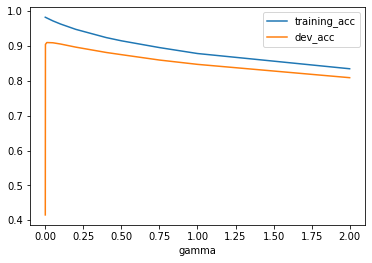

In [52]:
import pandas as pd
results=[]
for key,value in train_accs.items():
    results.append((key,value,dev_accs.get(key,0)))
accuracy_df=pd.DataFrame(results,columns=['gamma','training_acc','dev_acc'])
accuracy_df.plot(x='gamma')

In [53]:
gamma=0.01
smoothed_estimator = lambda fdist, bins: LidstoneProbDist(fdist,gamma,bins)
hmmTagger_smooth =hmmTrainer.train_supervised(train_sentences,estimator=smoothed_estimator)
hmmTagger_smooth.test(train_sentences)
hmmTagger_smooth.test(test_sentences)

accuracy over 80540 tokens: 97.94
accuracy over 20136 tokens: 90.60




### Extension
Find examples where the unigram tagger makes mistakes but the nltk hmm tagger is correct.  What different types of errors are being made?  Can you explain intuitively why the correct sequence predicted by the nltk hmm tagger is more likely than the one predicted by the unigram tagger?

In [54]:
import pandas as pd
def compare_pos_taggers(goldstandard,unigram_model):
    #this assumes flattened list so needs updating
    goldtoks,goldtags=zip(*goldstandard)
    pretoks,pretags=zip(*hmmTagger_smooth.tag(goldtoks))
    unitoks,unitags=zip(*uni_pos_tag(goldtoks,unigram_model))
    
    #find
    examples=[]
    for i,(gold,pre,uni) in enumerate(zip(goldtags,pretags,unitags)):
        if gold==pre and gold!=uni:
            examples.append(i)
        
    #display
    headers=['correct/pre','unigram','before','after']
    rows=[]
    for e in examples:
        rows.append([goldstandard[e],unitags[e],goldstandard[e-3:e],goldstandard[e+1:e+3]])
        
    df=pd.DataFrame(rows,columns=headers)
    return df

compare_pos_taggers(test,unigram_model)
    

,correct/pre,unigram,before,after
0,"(issue, VB)",NN,"[(ability, NN), (*, -NONE-), (to, TO)]","[(new, JJ), (debt, NN)]"
1,"(22\/32, CD)",NN,"[(*-1, -NONE-), (at, IN), (102, CD)]","[(*-2, -NONE-), (to, TO)]"
2,"(yield, VB)",NN,"[(22\/32, CD), (*-2, -NONE-), (to, TO)]","[(7.88, CD), (%, NN)]"
3,"(12\/32, CD)",NN,"[(compared, VBN), (with, IN), (102, CD)]","[(*, -NONE-), (to, TO)]"
4,"(yield, VB)",NN,"[(12\/32, CD), (*, -NONE-), (to, TO)]","[(7.90, CD), (%, NN)]"
...,...,...,...,...
984,"(lawmaking, JJ)",NN,"[(view, NN), (that, IN), (such, JJ)]","[(power, NN), (is, VBZ)]"
985,"(reach, NN)",VB,"[(is, VBZ), (beyond, IN), (the, DT)]","[('', ''), (of, IN)]"
986,"(claim, VB)",VBP,"[(President, NNP), (Bush, NNP), (to, TO)]","[(the, DT), (authority, NN)]"
987,"(reached, VBD)",VBN,"[(said, VBD), (0, -NONE-), (it, PRP)]","[(a, DT), (preliminary, JJ)]"


# Lecture Code for HMM Emission and Transition Probabilities

In [55]:
def calculate_emissions(trainlist):
    #trainlist is a list of (word,tag) pairs
    emissions={}
    for word,tag in trainlist:
        current=emissions.get(tag,{})
        current[word]=current.get(word,0)+1
        emissions[tag]=current
    return {tag:{word:value/sum(worddist.values()) for word,value in worddist.items()} 
            for tag,worddist in emissions.items()}
        

In [56]:
calculate_emissions(train)

ValueError: too many values to unpack (expected 2)

In [ ]:
def calculate_transitions(trainlist):
    transitions={}
    previous="start"
    for _, tag in trainlist:
        current=transitions.get(previous,{})
        current[tag]=current.get(tag,0)+1
        transitions[tag]=current
        previous =tag
    return {previous:{tag:value/sum(tagdist.values()) for tag,value in tagdist.items()} 
            for previous,tagdist in transitions.items()}
        

In [ ]:
calculate_transitions(train)